##  PURPOSE OF THIS NOTEBOOK IS TO CHECK IF ATTOM DATA SOLUTIONS API QUERY WORKS AND DEBUG AS NECESSARY

In [39]:
import requests
import json
import pandas as pd
import numpy as np
import time
from datetime import datetime
from dateutil.relativedelta import relativedelta
import altair as alt

## Attempted to fetch some data from ATTOM. See if query works

https://api.developer.attomdata.com/docs#!/Sales32Trend32by32Quarter/getSalesTrendByQuarter

In [ ]:
baseurl = 'https://api.gateway.attomdata.com/propertyapi/v1.0.0/property/address'
queryparams = {'postalcode':94536,
         'propertytype': 'TOWNHOUSE/ROWHOUSE', 
         'pagesize': 3}
headers = {'apikey': '522739f66b76ac63523c45dab14c3aa9', 'accept': 'application/JSON'}

In [ ]:
response = requests.get(baseurl, params = queryparams,headers=headers)
response.url


In [ ]:
pydata = response.json()    # pydata is a python list/dictionary NOT JSON
pydata = pydata['property']


In [ ]:
# UNCOMMENT TO SEE
#print(json.dumps(pydata, indent = 3))

In [ ]:
with open('exported.txt', 'w') as outfile:
    json.dump(pydata, outfile)

In [ ]:
import pandas as pd
with open('exported.txt') as project_file:    
    data = json.load(project_file)  

df = pd.json_normalize(data)


In [ ]:
df.shape

In [ ]:
pd.set_option('display.max_columns', 500)
df.head()

## conclusion: learnt to fetch data 
## convert responseobject ---> python list of dictionary of lists ---> write to file---> convert to pandas

## Fetch all counties in California FIPS ID

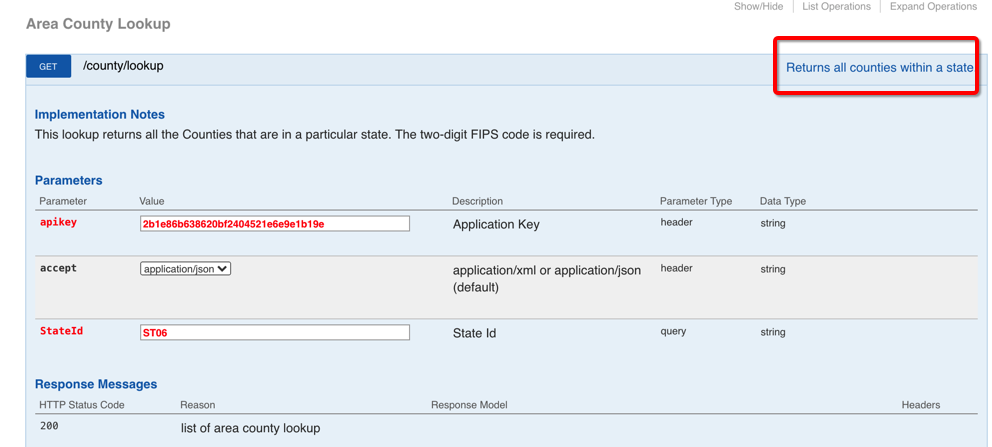

In [5]:

baseurl = 'https://api.gateway.attomdata.com/areaapi/v2.0.0/county/lookup'
queryparams = {'StateId':'ST06'}
headers = {'apikey': '522739f66b76ac63523c45dab14c3aa9', 'accept': 'application/JSON'}


response = requests.get(baseurl, params = queryparams,headers=headers)
pydata = response.json()  # convert to python list of dictionaroes
pydata

{'Response': {'status': {'version': '1.0.0',
   'code': '401',
   'msg': 'Unauthorized',
   'total': '0',
   'page': '0',
   'pagesize': '0'}}}

In [ ]:
# parsing the results to reach inner nest
pydata = pydata['response']['result']['package']['item']

In [4]:
with open('counties.txt', 'w') as outfile:
    json.dump(pydata, outfile)
with open('counties.txt') as project_file:    
    data = json.load(project_file)  

df_counties = pd.json_normalize(data)
df_counties  

NameError: name 'pydata' is not defined

In [ ]:
# extract geoIDs for counties and put them in a list
county_geoids = list(df_counties['id'])
# show first 10 county geoIDs out of 74
county_geoids[:10]

## there are 74 counties in california each with an ID or geoid

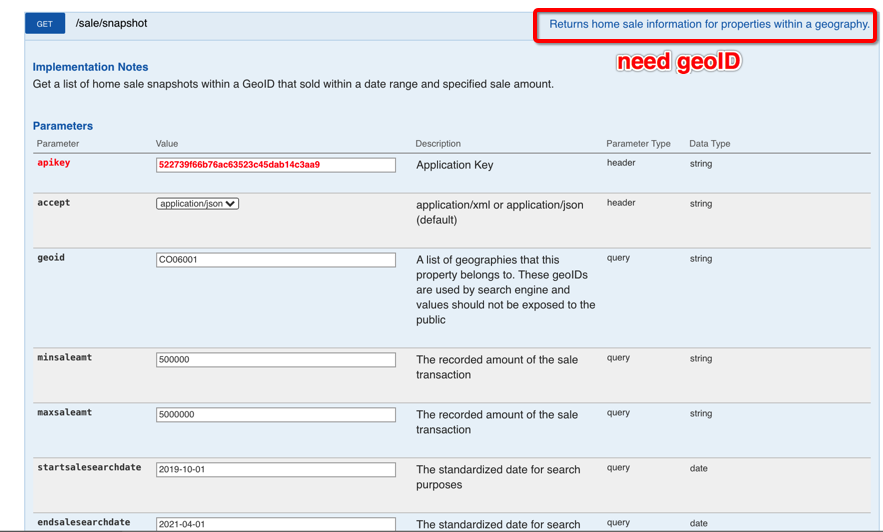

In [32]:
'C090055'+' '+'2019-10-01'


'C090055 2019-10-01'

In [ ]:
import datetime

In [168]:
# For each county, we'll make 1 API call and generated 1 text file containing sales data  
# county_geoids is the LIST of all 74 counties in California

# following function pulls all sales data between 1/2 million and 5 million dollars from start of covid
# function takes as input the geoID of the county 
# function outputs a generated text file containing JSON of all SALES transactions between $0.5M and $5M in that county
# function has defaults of from date of 1st Oct 2019 upto 1st april 2021. These can be changed as desired.
# i've set pagesize to 50,000 records for each county.

def salesdata_scraper_bycounty(county_geoid,from_date = '2019-01-01', duration_months = 12): 
    
    baseurl = 'https://api.gateway.attomdata.com/propertyapi/v1.0.0/sale/snapshot'
    queryparams = {'geoid':county_geoid, 
               'minsaleamt': 200000,
               'maxsaleamt': 50000000, 
              'startsalesearchdate':from_date,
               'endsalesearchdate': ((pd.to_datetime(from_date) + relativedelta(months=duration_months)).strftime("%Y-%m-%d")),
                'pagesize' :50000}        
    headers = {'apikey': 'c58f4207c853970536fdea21a30ef864', 'accept': 'application/JSON'}
    
    response = requests.get(baseurl, params = queryparams,headers=headers)
    pydata = response.json()         # converting response object to python list of dictionaries
    print(pydata)
    number_of_records = pydata['status']['total']
    if number_of_records > 0:   # this condition is to avoid writing empty files in case of zero transactions in a county
        if number_of_records == 10000:
            print('{} county has over 10000 records. Truncated.Run query separately by month instead of year'.format(county_geoid))
        else:    # no files will be created right now for counti 10,000 records     
            pydata = pydata['property']   # this is to reach inner nested part where our results lie
            with open(county_geoid+' '+from_date, 'w') as outfile:   # The name of each file will be CO06001, CO06003, etc.74 files created            
                json.dump(pydata, outfile) 


In [ ]:
# Following happened when API calls exceeded per minute. Created NEW API key on my gmail account as above
salesdata_scraper_bycounty(county_geoids[50])

## Cannot iterate all 74 counties in 1 for loop. API request times out/doesn't return status header. Its blank. Had to do in 7 batches of 10 calls each per for loop as belo.

In [ ]:
for county_geoid in county_geoids[70:]:   # change [0:10], [10:20], [20:30], etc
    salesdata_scraper_bycounty(county_geoid)
print('done')

## Following shows each of the 71 files can be imported into a dataframe for processing. There will be 1 dataframe for 1 county.

In [ ]:
with open('CO06027') as project_file:   # open 1 of the 71 JSON files created and read them as dataframe
        data = json.load(project_file)  
df = pd.json_normalize(data)   

print(df.shape)
df.head()

## Try from date from 2015, Try low limit 200K. upper limit 50 million dollars

In [133]:
with open('counties_pull.txt') as project_file:    
    data = json.load(project_file)  

df_counties = pd.json_normalize(data)

county_geoids = list(df_counties['id'])
county_geoids[:9]

['CO06001',
 'CO06003',
 'CO06005',
 'CO06007',
 'CO06009',
 'CO32510',
 'CO32003',
 'CO06011',
 'CO06013']

In [18]:
with open('CO06001') as project_file:   # open 1 of the 71 JSON files created and read them as dataframe
        data = json.load(project_file)  
df = pd.json_normalize(data)   

print(df.shape)
df['sale.saleTransDate']

(10000, 43)


0       2015-1-2
1       2015-1-2
2       2015-1-2
3       2015-1-2
4       2015-1-2
          ...   
9995    2017-6-6
9996    2017-6-6
9997    2017-6-6
9998    2017-6-6
9999    2017-6-6
Name: sale.saleTransDate, Length: 10000, dtype: object

## Challenge: We realized some counties fetch exactly 10000 transactions. How can that be? It must be that its truncating first 10000 results and likely there are more. On further examination, found that if we start from 2015 to 2021, it only pulls from 2015-1-2 upto 2017-6-6. Even in 2015, there are 10000 records fetched in just 3 months

In [142]:
highvolume_counties = ['CO06001','CO32003', 'CO06013', 'CO06037', 'CO06059',
                       'CO06065', 'CO06067', 'CO06071', 'CO06073', 'CO06085']
lowvolume_counties = [i for i in county_geoids if i not in highvolume_counties]


64

In [155]:
lowvolume_counties

['CO06003',
 'CO06005',
 'CO06007',
 'CO06009',
 'CO32510',
 'CO06011',
 'CO41015',
 'CO06015',
 'CO32005',
 'CO06017',
 'CO32009',
 'CO06019',
 'CO06021',
 'CO06023',
 'CO06025',
 'CO06027',
 'CO41029',
 'CO41033',
 'CO06029',
 'CO06031',
 'CO41035',
 'CO04012',
 'CO41037',
 'CO06033',
 'CO06035',
 'CO32019',
 'CO06039',
 'CO06041',
 'CO06043',
 'CO06045',
 'CO06047',
 'CO32021',
 'CO06049',
 'CO04015',
 'CO06051',
 'CO06053',
 'CO06055',
 'CO06057',
 'CO32023',
 'CO06061',
 'CO06063',
 'CO06069',
 'CO06075',
 'CO06077',
 'CO06079',
 'CO06081',
 'CO06083',
 'CO06087',
 'CO06089',
 'CO06091',
 'CO06093',
 'CO06095',
 'CO06097',
 'CO06099',
 'CO06101',
 'CO06103',
 'CO06105',
 'CO06107',
 'CO06109',
 'CO06111',
 'CO32031',
 'CO06113',
 'CO06115',
 'CO04027']

In [169]:
salesdata_scraper_bycounty('CO06115', from_date = '2020-01-01')

{'Response': {'status': {'version': '1.0.0', 'code': '401', 'msg': 'Usage limits are exceeded with SalesSnapshot', 'total': '0', 'page': '0', 'pagesize': '0'}}}


KeyError: 'status'

In [156]:
for county in lowvolume_counties[7:10]:
    salesdata_scraper_bycounty(county, from_date = '2020-01-01', duration_months = 12)   # last optional parameter is number of months
    time.sleep(30)   # this 10 second lag is only to prevent hitting API limit of 10 calls per Minute.
print('done')

Connection error or timeout
Connection error or timeout


KeyboardInterrupt: 

### challenges: ConnectionError: ('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer'))

In [117]:
salesdata_scraper_bycounty('CO06001', from_date = '2019-01-01')
print('done')

done


In [17]:
with open('/Users/adityahpatel/Desktop/PYTHON PROGRAMS/2019 California Housing Sales transactions FULL/CO04012 2019-01-01') as project_file:   # open 1 of the 71 JSON files created and read them as dataframe
        data = json.load(project_file)  
df = pd.json_normalize(data)   

print(df.shape)
pd.set_option('display.max_columns', None)
df.head()
df.columns

(136, 43)


Index(['identifier.obPropId', 'identifier.fips', 'identifier.apn',
       'identifier.apnOrig', 'identifier.attomId', 'lot.lotSize1',
       'address.country', 'address.countrySubd', 'address.line1',
       'address.line2', 'address.locality', 'address.matchCode',
       'address.oneLine', 'address.postal1', 'address.postal2',
       'address.postal3', 'location.accuracy', 'location.elevation',
       'location.latitude', 'location.longitude', 'location.distance',
       'location.geoid', 'summary.propclass', 'summary.propsubtype',
       'summary.proptype', 'summary.yearbuilt', 'summary.propLandUse',
       'summary.propIndicator', 'building.size.universalsize',
       'building.rooms.bathstotal', 'building.rooms.beds',
       'vintage.lastModified', 'vintage.pubDate', 'sale.salesearchdate',
       'sale.saleTransDate', 'sale.amount.saleamt', 'sale.amount.salecode',
       'sale.amount.salerecdate', 'sale.amount.saledisclosuretype',
       'sale.amount.saledocnum', 'sale.amount.saletr

In [20]:
cols = ['summary.yearbuilt','summary.propsubtype','lot.lotSize1','building.size.universalsize','sale.amount.salerecdate','sale.amount.saleamt' ]
df = df[cols]
sample = df.head(6)
sample

,summary.yearbuilt,summary.propsubtype,lot.lotSize1,building.size.universalsize,sale.amount.salerecdate,sale.amount.saleamt
0,2004,HOUSE,0.1472,2651,2019-1-7,550000
1,2005,HOUSE,0.2764,1800,2019-1-30,235000
2,1994,HOUSE,0.1722,2754,2019-2-5,270000
3,2007,COMMERCIAL,0.3034,3735,2019-1-24,244000
4,2001,HOUSE,1.1140,3169,2019-2-15,450000
5,2006,HOUSE,9.7700,2112,2019-2-20,239000


In [26]:
covid_cases = [3000, 3200, 2500, 2600, 3200, 3300]
sample['covid_cases'] = covid_cases
sample

<ipython-input-26-4a9a57afcbe4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['covid_cases'] = covid_cases


,summary.yearbuilt,summary.propsubtype,lot.lotSize1,building.size.universalsize,sale.amount.salerecdate,sale.amount.saleamt,covid_cases
0,2004,HOUSE,0.1472,2651,2019-1-7,550000,3000
1,2005,HOUSE,0.2764,1800,2019-1-30,235000,3200
2,1994,HOUSE,0.1722,2754,2019-2-5,270000,2500
3,2007,COMMERCIAL,0.3034,3735,2019-1-24,244000,2600
4,2001,HOUSE,1.1140,3169,2019-2-15,450000,3200
5,2006,HOUSE,9.7700,2112,2019-2-20,239000,3300


In [27]:
sample.columns = ['year_built', 'property_type', 'lot_size', 'building_size', 'sale_date', 'sale_price', 'Covid_cases_number']
sample

,year_built,property_type,lot_size,building_size,sale_date,sale_price,Covid_cases_number
0,2004,HOUSE,0.1472,2651,2019-1-7,550000,3000
1,2005,HOUSE,0.2764,1800,2019-1-30,235000,3200
2,1994,HOUSE,0.1722,2754,2019-2-5,270000,2500
3,2007,COMMERCIAL,0.3034,3735,2019-1-24,244000,2600
4,2001,HOUSE,1.1140,3169,2019-2-15,450000,3200
5,2006,HOUSE,9.7700,2112,2019-2-20,239000,3300


In [60]:
df = pd.read_csv('/Users/adityahpatel/Desktop/PYTHON PROGRAMS/csv files/covid19cases_test.csv')

In [61]:
df.area.unique()

array(['Alameda', 'Alpine', 'Amador', 'Butte', 'Calaveras', 'California',
       'Colusa', 'Contra Costa', 'Del Norte', 'El Dorado', 'Fresno',
       'Glenn', 'Humboldt', 'Imperial', 'Inyo', 'Kern', 'Kings', 'Lake',
       'Lassen', 'Los Angeles', 'Madera', 'Marin', 'Mariposa',
       'Mendocino', 'Merced', 'Modoc', 'Mono', 'Monterey', 'Napa',
       'Nevada', 'Orange', 'Out of state', 'Placer', 'Plumas',
       'Riverside', 'Sacramento', 'San Benito', 'San Bernardino',
       'San Diego', 'San Francisco', 'San Joaquin', 'San Luis Obispo',
       'San Mateo', 'Santa Barbara', 'Santa Clara', 'Santa Cruz',
       'Shasta', 'Sierra', 'Siskiyou', 'Solano', 'Sonoma', 'Stanislaus',
       'Sutter', 'Tehama', 'Trinity', 'Tulare', 'Tuolumne', 'Unknown',
       'Ventura', 'Yolo', 'Yuba'], dtype=object)

In [62]:
condition = (df.area == 'Sacramento')
sacramento = df[condition]
sacramento

,date,area,area_type,population,cases,deaths,total_tests,positive_tests,reported_cases,reported_deaths,reported_tests
35,2021-04-21,Sacramento,County,1567975.0,0.0,0.0,NaN,NaN,174.0,5.0,8648.0
96,2021-04-20,Sacramento,County,1567975.0,9.0,0.0,615.0,12.0,147.0,2.0,3405.0
157,2021-04-19,Sacramento,County,1567975.0,109.0,0.0,5686.0,133.0,128.0,0.0,3836.0
218,2021-04-18,Sacramento,County,1567975.0,65.0,0.0,1824.0,78.0,182.0,0.0,6722.0
279,2021-04-17,Sacramento,County,1567975.0,82.0,0.0,2267.0,91.0,179.0,0.0,7275.0
340,2021-04-16,Sacramento,County,1567975.0,162.0,0.0,6087.0,196.0,211.0,2.0,9347.0
401,2021-04-15,Sacramento,County,1567975.0,178.0,0.0,6632.0,212.0,137.0,0.0,8193.0
462,2021-04-14,Sacramento,County,1567975.0,176.0,1.0,7180.0,221.0,94.0,1.0,4914.0
523,2021-04-13,Sacramento,County,1567975.0,177.0,1.0,8841.0,213.0,157.0,3.0,3723.0
584,2021-04-12,Sacramento,County,1567975.0,179.0,2.0,10264.0,239.0,98.0,0.0,3265.0


In [27]:
df.head()

,date,area,area_type,population,cases,deaths,total_tests,positive_tests,reported_cases,reported_deaths,reported_tests
0,2021-04-21,Alameda,County,1685886.0,0.0,0.0,NaN,NaN,110.0,1.0,20804.0
1,2021-04-21,Alpine,County,1117.0,0.0,0.0,NaN,NaN,1.0,0.0,10.0
2,2021-04-21,Amador,County,38531.0,0.0,0.0,NaN,NaN,1.0,0.0,309.0
3,2021-04-21,Butte,County,217769.0,0.0,0.0,NaN,NaN,24.0,0.0,730.0
4,2021-04-21,Calaveras,County,44289.0,0.0,0.0,NaN,NaN,4.0,0.0,116.0


In [70]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
condition = (df.area == 'Alameda')
df['date'] =pd.to_datetime(df['date'])
alameda = df[condition]
alameda


,date,area,area_type,population,cases,deaths,total_tests,positive_tests,reported_cases,reported_deaths,reported_tests
0,2021-04-21,Alameda,County,1685886.0,0.0,0.0,NaN,NaN,110.0,1.0,20804.0
61,2021-04-20,Alameda,County,1685886.0,10.0,0.0,952.0,11.0,69.0,1.0,6553.0
122,2021-04-19,Alameda,County,1685886.0,63.0,0.0,7407.0,69.0,102.0,0.0,5570.0
183,2021-04-18,Alameda,County,1685886.0,31.0,0.0,2401.0,35.0,114.0,0.0,7912.0
244,2021-04-17,Alameda,County,1685886.0,58.0,0.0,3287.0,67.0,124.0,2.0,10656.0
305,2021-04-16,Alameda,County,1685886.0,123.0,0.0,8316.0,148.0,154.0,-1.0,10152.0
366,2021-04-15,Alameda,County,1685886.0,106.0,0.0,9351.0,135.0,80.0,-1.0,9252.0
427,2021-04-14,Alameda,County,1685886.0,104.0,0.0,10281.0,130.0,88.0,8.0,6959.0
488,2021-04-13,Alameda,County,1685886.0,113.0,0.0,11354.0,141.0,104.0,1.0,7178.0
549,2021-04-12,Alameda,County,1685886.0,102.0,0.0,13377.0,135.0,61.0,0.0,4336.0


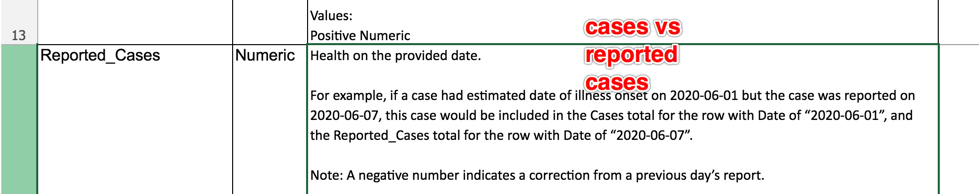

In [58]:
condition = (df.area == 'Los Angeles')

los_angeles = df[condition]
los_angeles

,date,area,area_type,population,cases,deaths,total_tests,positive_tests,reported_cases,reported_deaths,reported_tests
19,2021-04-21,Los Angeles,County,10257557.0,0.0,0.0,NaN,NaN,274.0,35.0,43476.0
80,2021-04-20,Los Angeles,County,10257557.0,10.0,0.0,346.0,5.0,311.0,28.0,56544.0
141,2021-04-19,Los Angeles,County,10257557.0,207.0,2.0,5160.0,54.0,325.0,18.0,67432.0
202,2021-04-18,Los Angeles,County,10257557.0,171.0,4.0,13426.0,172.0,358.0,-5.0,79574.0
263,2021-04-17,Los Angeles,County,10257557.0,227.0,4.0,36588.0,412.0,444.0,26.0,89005.0
324,2021-04-16,Los Angeles,County,10257557.0,324.0,2.0,73741.0,609.0,544.0,29.0,77120.0
385,2021-04-15,Los Angeles,County,10257557.0,371.0,5.0,77186.0,642.0,453.0,19.0,58526.0
446,2021-04-14,Los Angeles,County,10257557.0,370.0,5.0,81991.0,712.0,339.0,53.0,34896.0
507,2021-04-13,Los Angeles,County,10257557.0,452.0,6.0,79972.0,720.0,337.0,21.0,32163.0
568,2021-04-12,Los Angeles,County,10257557.0,451.0,4.0,89827.0,676.0,388.0,2.0,61336.0


In [47]:
alt.Chart(alameda).mark_line().encode(
    x = alt.X('date:T'),
    y = alt.Y('reported_cases:Q')).properties(width = 800, height = 400)

alt.Chart(...)

In [72]:
# Source: https://usafacts.org/visualizations/coronavirus-covid-19-spread-map/state/california
# Why this dataset is valid? Cross-check:
# (1) This dataset makes sense because LA county saw 1st case on 26th Jan 2020 acc to google (validates with this dataset)
# (2) Also, 1st case in Alameda county was reported on 3rd March 2020, this dataset validates that too!
# This dataset gives 58 counties
#
# 
# According to https://calmatters.org/health/coronavirus/2021/03/timeline-california-pandemic-year-key-points/
# Jan 30th 2020 - Just 5 confirmed cases in USA. 
# Jan 31st 2020 - 7 cases in USA. Norcal case reported in Santa Clara
# Mar 6th 2020 - President Trump signs $8.3 billion coronavirus relief bill. The bill provides money to assist 
#     in the development of a vaccine and treatment, loans for small businesses and cash for state and local 
#     governments.
#  Mar 7th - 1st school closes in California Elk Grove Unified School district
# March 12th 2020 - Disneyland closes Southern California theme park
# March 13, 2020 - Schools in California close 5.7 million K-12 kids sent home
# Mar 16th - Newson orders restaurants dine-out only + 7 bay area counties execute shelter orders.
# Mar 19th - Newsom orders Statewide shelter at home orders
#
#
#
#


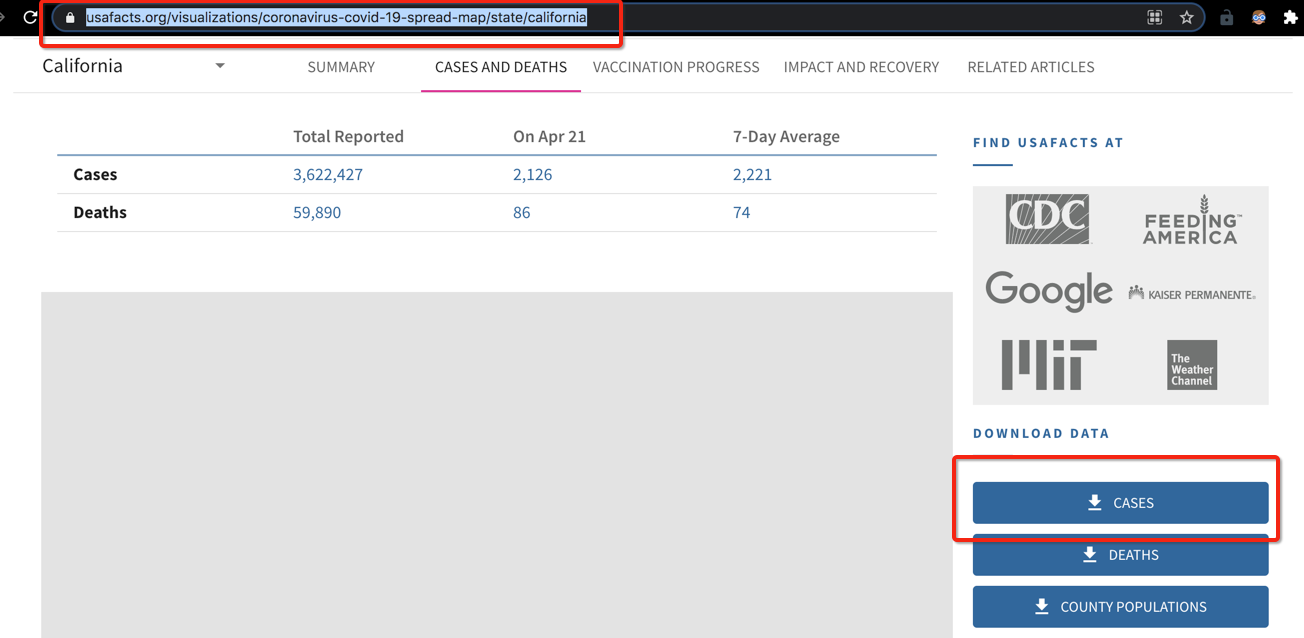

### I can find data for any county of any state in USA. Dataset is comprehensive

In [83]:
s = pd.read_csv('/Users/adityahpatel/Desktop/PYTHON PROGRAMS/Milestone Project/covid_confirmed_usafacts.csv')
cali = s[s.State == 'CA']   
cali

,countyFIPS,County Name,State,StateFIPS,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,2020-02-16,2020-02-17,2020-02-18,2020-02-19,2020-02-20,2020-02-21,2020-02-22,2020-02-23,2020-02-24,2020-02-25,2020-02-26,2020-02-27,2020-02-28,2020-02-29,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14,2020-03-15,2020-03-16,2020-03-17,2020-03-18,2020-03-19,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29,2020-03-30,2020-03-31,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05,2020-04-06,2020-04-07,2020-04-08,2020-04-09,2020-04-10,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20,2020-04-21,2020-04-22,2020-04-23,2020-04-24,2020-04-25,2020-04-26,2020-04-27,2020-04-28,2020-04-29,2020-04-30,2020-05-01,2020-05-02,2020-05-03,2020-05-04,2020-05-05,2020-05-06,2020-05-07,2020-05-08,2020-05-09,2020-05-10,2020-05-11,2020-05-12,2020-05-13,2020-05-14,2020-05-15,2020-05-16,2020-05-17,2020-05-18,2020-05-19,2020-05-20,2020-05-21,2020-05-22,2020-05-23,2020-05-24,2020-05-25,2020-05-26,2020-05-27,2020-05-28,2020-05-29,2020-05-30,2020-05-31,2020-06-01,2020-06-02,2020-06-03,2020-06-04,2020-06-05,2020-06-06,2020-06-07,2020-06-08,2020-06-09,2020-06-10,2020-06-11,2020-06-12,2020-06-13,2020-06-14,2020-06-15,2020-06-16,2020-06-17,2020-06-18,2020-06-19,2020-06-20,2020-06-21,2020-06-22,2020-06-23,2020-06-24,2020-06-25,2020-06-26,2020-06-27,2020-06-28,2020-06-29,2020-06-30,2020-07-01,2020-07-02,2020-07-03,2020-07-04,2020-07-05,2020-07-06,2020-07-07,2020-07-08,2020-07-09,2020-07-10,2020-07-11,2020-07-12,2020-07-13,2020-07-14,2020-07-15,2020-07-16,2020-07-17,2020-07-18,2020-07-19,2020-07-20,2020-07-21,2020-07-22,2020-07-23,2020-07-24,2020-07-25,2020-07-26,2020-07-27,2020-07-28,2020-07-29,2020-07-30,2020-07-31,2020-08-01,2020-08-02,2020-08-03,2020-08-04,2020-08-05,2020-08-06,2020-08-07,2020-08-08,2020-08-09,2020-08-10,2020-08-11,2020-08-12,2020-08-13,2020-08-14,2020-08-15,2020-08-16,2020-08-17,2020-08-18,2020-08-19,2020-08-20,2020-08-21,2020-08-22,2020-08-23,2020-08-24,2020-08-25,2020-08-26,2020-08-27,2020-08-28,2020-08-29,2020-08-30,2020-08-31,2020-09-01,2020-09-02,2020-09-03,2020-09-04,2020-09-05,2020-09-06,2020-09-07,2020-09-08,2020-09-09,2020-09-10,2020-09-11,2020-09-12,2020-09-13,2020-09-14,2020-09-15,2020-09-16,2020-09-17,2020-09-18,2020-09-19,2020-09-20,2020-09-21,2020-09-22,2020-09-23,2020-09-24,2020-09-25,2020-09-26,2020-09-27,2020-09-28,2020-09-29,2020-09-30,2020-10-01,2020-10-02,2020-10-03,2020-10-04,2020-10-05,2020-10-06,2020-10-07,2020-10-08,2020-10-09,2020-10-10,2020-10-11,2020-10-12,2020-10-13,2020-10-14,2020-10-15,2020-10-16,2020-10-17,2020-10-18,2020-10-19,2020-10-20,2020-10-21,2020-10-22,2020-10-23,2020-10-24,2020-10-25,2020-10-26,2020-10-27,2020-10-28,2020-10-29,2020-10-30,2020-10-31,2020-11-01,2020-11-02,2020-11-03,2020-11-04,2020-11-05,2020-11-06,2020-11-07,2020-11-08,2020-11-09,2020-11-10,2020-11-11,2020-11-12,2020-11-13,2020-11-14,2020-11-15,2020-11-16,2020-11-17,2020-11-18,2020-11-19,2020-11-20,2020-11-21,2020-11-22,2020-11-23,2020-11-24,2020-11-25,2020-11-26,2020-11-27,2020-11-28,2020-11-29,2020-11-30,2020-12-01,2020-12-02,2020-12-03,2020-12-04,2020-12-05,2020-12-06,2020-12-07,2020-12-08,2020-12-09,2020-12-10,2020-12-11,2020-12-12,2020-12-13,2020-12-14,2020-12-15,2020-12-16,2020-12-17,2020-12-18,2020-12-19,2020-12-20,2020-12-21,2020-12-22,2020-12-23,2020-12-24,2020-12-25,2020-12-26,2020-12-27,2020-12-28,2020-12-29,2020-12-30,2020-12-31,2021-01-01,2021-01-02,2021-01-03,2021-01-04,2021-01-05,2021-01-06,2021-01-07,2021-01-08,2021-01-09,2021-01-10,2021-01-11,2021-01-12,2021-01-13,2021-01-14,2021-01-15,

In [80]:
cali['County Name'].unique()

array(['Statewide Unallocated', 'Alameda County ', 'Alpine County ',
       'Amador County ', 'Butte County ', 'Calaveras County ',
       'Colusa County ', 'Contra Costa County ', 'Del Norte County ',
       'El Dorado County ', 'Fresno County ', 'Glenn County ',
       'Humboldt County ', 'Imperial County ', 'Inyo County ',
       'Kern County ', 'Kings County ', 'Lake County ', 'Lassen County ',
       'Los Angeles County ', 'Madera County ', 'Marin County ',
       'Mariposa County ', 'Mendocino County ', 'Merced County ',
       'Modoc County ', 'Mono County ', 'Monterey County ',
       'Napa County ', 'Nevada County ', 'Orange County ',
       'Placer County ', 'Plumas County ', 'Riverside County ',
       'Sacramento County ', 'San Benito County ',
       'San Bernardino County ', 'San Diego County ',
       'City and County of San Francisco', 'San Joaquin County ',
       'San Luis Obispo County ', 'San Mateo County ',
       'Santa Barbara County ', 'Santa Clara County ',
   

## professor shared "how does covid-19 affect house prices? A cross-city analysis" Bingbing Wang. Here author uses treatment as TIME instead of GEOGRAPHY. 

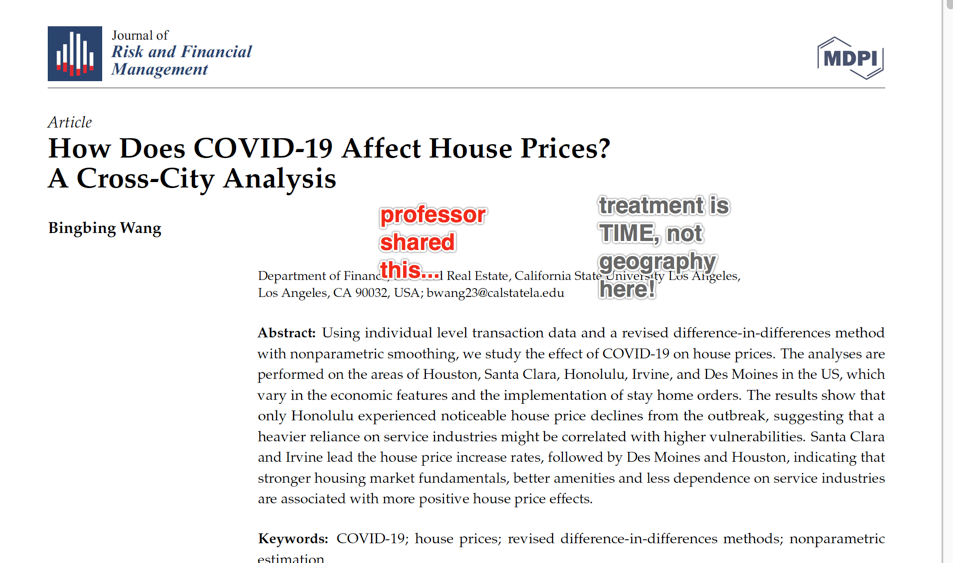

In [ ]:
# Challenges Differences in Differences approach:
# How to choose treatment and control group? i.e. decide how to define the "treatment"? 
# 2 options: 
# (1) Use time as treatment i.e. March '20 to Oct '20 as treatment and Oct 19 - Feb 20 as control 
# (2) Use 2 different counties where Covid hit one earlier, so that at t=1, 1 county hit 5000 cases, other didn't
# Read paper How does Covid affect house prices? A cross city analysis by BingBing Wang 
#
# When policy changes or treatments are imposed on people, it is common and reasonable to ask how those people have been impacted. 
# This is a more difficult question than it seems at first glance.

# In order to truly know how those individuals have been impacted, we need to consider how those individuals 
# would be had the policies or treatments not taken place. However, the changes did take place, and we don't
# get to observe how those individuals would fair without those changes.
#
# Difference-in-differences estimation attempts to measure the effects of a sudden change in economic environment,
# policy, or general treatment on a group of individuals.
#
# DD uses the outcome of the control group as a proxy for what would have occurred in the treatment group had 
# there been no treatment. The difference in the average post-treatment outcomes between the treatment and 
# control groups is then used to measure the treatment effects.
#
# The DD model includes several pieces:
# A sudden exogenous source of variation (i.e. CHANGE), which we will refer to as the treatment. Treatment examples include 
# changes in minimum wage, a new workplace non-discrimination policy, Covid cases reaching a threshold, 
# a new CO2 emissions tax, etc.
# A quantifiable and measurable outcome which is either the direct target of the variation or an indirect proxy.
# A treatment group which is subjected to the CHANGE.
# A control group which is similar in characteristic to the treatment group (i.e same square foot, bedrooms)
#             but is NOT subjected to the CHANGE.

# 

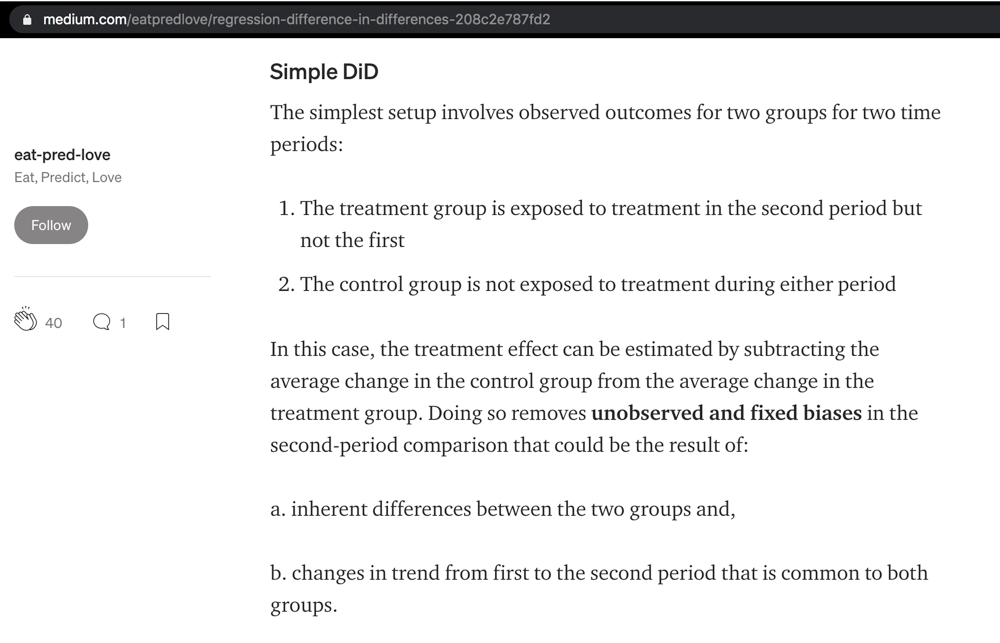

## PLEASE READ 
https://medium.com/coursera-engineering/analyzing-the-impact-of-course-updates-with-difference-in-differences-9a0704be131c

In [84]:
# DIFFERENCE IN DIFFERENCE HAS 2 DIFFERENCES
# DIFFERENCE OVER TIME ACROSS BOTH GROUPS
# DIFFERENCE IN 2 GROUPS DUE TO TREATMENT.
#  T = 0 CONTROL GROUP   TREATMENT GROUP
#  T = 1 CONTROL GROUP   TREATMENT GROUP
# DRAW 2 * 2 MATRIX AS IN LECTURE

### visually inspect for parallel trends  + do DiD regression

In [ ]:
# CAUSAL INFERENCE of Covid on home prices (we choose Single Family Home or Townhome ) 

# Difference-in-differences estimation attempts to measure the effects of a sudden change in economic environment,
# policy, or general treatment on a group of individuals. Sudden onset of Covid is a classic example of such a change.


# Set up: Discussion with Prof. Alain Cohn on setting up simple DiD 
# (Assumptions listed as A1, A2)

# (1) A1: Define hypothesis. What do u believe happened to prices? Intuition. 
#     Ppl left California or to rentals due to foreclosure, etc. 

# (2) Identify 2 counties (treatment and control) preferably in same state 
#     where Covid cases reached a threshold (A2: 10K cases, when ppl startes losing jobs and not when
#     1st cases was reported...companies realized this virus is here to stay) at 2 different points of time..

# (3) Alameda county hit 5000 cases 06/22/2020 and 10,000 cases on 07/24/2020
#     Sacramento county hit 5000 cases 07/10/2020 and 10,000 cases on 08/01/2020
#     Los Angeles county hit 5000 cases 04/04/2020 and 10,000 cases on 04/14/2020
#     San Francisco county hit 5000 cases on 07/18/2020 and 10,000 cases on 09/08

# We define treatment as Covid cases reaching a critical threshold of 10,000 cases. 

# Treatment Group: Los Angeles county (exposed to treatment in period 2 but NOT in period 1)
# Control Group: San Francisco county (not exposed to treatment in either period 1 or period 2)

# Period 2: 04/14/2020 to 05/14/2020 (Post Treatment Period)
# Period 1: 04/14/2019 to 05/14/2019 (Pre-Treatment Period)

# In Period 1, both counties (treatment and control) were had no Covid 
# In Period 2, treatment county saw Covid hit critical threshold, but control county did not

# Calculate simple Difference-in-Difference of Median Home Price of Single Family Homes as the causal effect of
# Covid on Home Prices in Los Angeles county

In [ ]:
# Visualization:
# Create 